# Exploratory Data Analysis and Preprocessing of Fall Detection and Human Activity Recognition Dataset
This notebook contains the code for exploratory analysis of the IMU dataset, along with the preprocessing steps for data preparations.

<ins>References</ins>
- Dataset ([Heart Rate and IMU Sensor Data for Fall Detection](https://github.com/nhoyh/hr_imu_falldetection_dataset))
- Accompanying Article ([Nho, Lim & Kwon, 2020](https://ieeexplore.ieee.org/document/8970371))

In [1]:
from utils import *
from mat4py import loadmat
from sklearn.preprocessing import LabelEncoder
import os, re
import matplotlib.pyplot as plt

## Import Fall-Detection Dataset
Load dataset into a `pandas` dataframe by reading the `*.mat` files.

In [2]:
# Initialise empty dataframe
df_dataset = pd.DataFrame(columns=['subject', 'time', 'w', 'x', 'y', 'z', 'droll', 'dpitch', 'dyaw', 'ax', 'ay', 'az', 'heart', 'scenario', 'class'])

# Iterate through each subject folder
for folder in os.listdir(DATASET_FOLDER):
    current_folder = os.path.join(DATASET_FOLDER, folder)
    if("subject" in folder):
        subject = folder
        # Iterate through each class (fall or non-fall)
        for fall_class in os.listdir(current_folder):
            current_path = os.path.join(current_folder, fall_class)
            # Iterate through each file
            for file in os.listdir(current_path):
                regex_match = re.match("(.+)\\.mat", file)
                if(regex_match):
                    # Load the .mat file
                    data = loadmat(os.path.join(current_path, file))
                    data['subject'] = subject
                    data['scenario'] = regex_match.group(1)
                    data['class'] = fall_class
                    df_dataset.loc[len(df_dataset)] = data

# Add demographic data
demographic_data = {
                    "subject_01": {"age": 31, "sex": "Male" },
                    "subject_02": {"age": 21, "sex": "Female" },
                    "subject_03": {"age": 28, "sex": "Male" },
                    "subject_04": {"age": 25, "sex": "Male" },
                    "subject_05": {"age": 21, "sex": "Female" },
                    "subject_06": {"age": 28, "sex": "Male" },
                    "subject_07": {"age": 32, "sex": "Male" },
                    "subject_08": {"age": 22, "sex": "Female" },
                    "subject_09": {"age": 27, "sex": "Male" },
                    "subject_10": {"age": 25, "sex": "Male" },
                    "subject_11": {"age": 27, "sex": "Male" },
                    "subject_12": {"age": 26, "sex": "Male" },
                    "subject_13": {"age": 21, "sex": "Female" },
                    "subject_14": {"age": 21, "sex": "Female" },
                    "subject_15": {"age": 29, "sex": "Female" },
                    "subject_16": {"age": 30, "sex": "Male" },
                    "subject_17": {"age": 23, "sex": "Female" },
                    "subject_18": {"age": 28, "sex": "Male" },
                    "subject_19": {"age": 25, "sex": "Male" },
                    "subject_20": {"age": 21, "sex": "Female" },
                    "subject_21": {"age": 30, "sex": "Male" }
                }
df_dataset['age'] = df_dataset['subject'].map(lambda x: demographic_data[x]['age'] if x in demographic_data else None)
df_dataset['sex'] = df_dataset['subject'].map(lambda x: demographic_data[x]['sex'] if x in demographic_data else None)

# Reorder columns and sort dataset
df_dataset = df_dataset[['subject', 'age', 'sex', 'class', 'scenario', 'time', 'w', 'x', 'y', 'z', 'droll', 'dpitch', 'dyaw', 'ax', 'ay', 'az', 'heart']]
df_dataset = df_dataset.sort_values(by=['subject', 'class', 'scenario'])
df_dataset.reset_index(inplace=True, drop=True)

# Encode the scenario and class labels
label_encoder = LabelEncoder()
df_dataset['scenario_encoded'] = label_encoder.fit_transform(df_dataset['scenario'])
print("Scenario mapping:", dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_)))
df_dataset['class_encoded'] = label_encoder.fit_transform(df_dataset['class'])
print("Class mapping:", dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_)))

# Export dataframe
pickle_object(df_dataset, DATASET_FILE)

Scenario mapping: {0: 'bed', 1: 'chair', 2: 'clap', 3: 'cloth', 4: 'eat', 5: 'fall1', 6: 'fall2', 7: 'fall3', 8: 'fall4', 9: 'fall5', 10: 'fall6', 11: 'hair', 12: 'shoe', 13: 'stair', 14: 'teeth', 15: 'walk', 16: 'wash', 17: 'write', 18: 'zip'}
Class mapping: {0: 'fall', 1: 'non-fall'}


We will perform binary classification of the dataset using the `class` or `class_encoded` column for Fall Detection (FD). We will also perform multi-class classification of the dataset for Human Activity Recognition (HAR), using the `scenario` or `scenario_encoded` column for the detection of the various fall and non-fall scenarios.

## Preliminary Analysis

In [4]:
print("Dimensions of preliminary dataset:", df_dataset.shape)

Dimensions of preliminary dataset: (349, 19)


In [5]:
df_dataset.head()

,subject,age,sex,class,scenario,time,w,x,y,z,droll,dpitch,dyaw,ax,ay,az,heart,scenario_encoded,class_encoded
0,subject_01,31,Male,fall,fall1,"[[2018.0, 5.0, 11.0, 13.0, 17.0, 2.825], [2018...","[[-0.8331], [-0.8331], [-0.8331], [-0.8331], [...","[[0.4897], [0.4897], [0.4897], [0.4897], [0.48...","[[0.1678], [0.1679], [0.168], [0.1679], [0.168...","[[-0.1942], [-0.1942], [-0.1942], [-0.1943], [...","[[-0.7], [-0.9], [-0.4], [-0.4], [-0.5], [-0.8...","[[0.0], [0.2], [0.1], [0.2], [0.2], [0.1], [0....","[[1.1], [0.8], [0.8], [0.9], [1.1], [0.9], [1....","[[0.016], [0.015], [0.018], [0.016], [0.015], ...","[[0.014], [0.01], [0.012], [0.013], [0.012], [...","[[0.002], [0.006], [0.002], [0.002], [0.008], ...","[[1023], [1023], [1023], [1023], [1023], [1023...",5,0
1,subject_01,31,Male,fall,fall2,"[[2018.0, 5.0, 11.0, 13.0, 23.0, 23.547], [201...","[[-0.2803], [-0.2803], [-0.2802], [-0.2802], [...","[[-0.6516], [-0.6518], [-0.652], [-0.6521], [-...","[[0.6375], [0.6374], [0.6372], [0.637], [0.636...","[[0.3003], [0.3003], [0.3003], [0.3003], [0.30...","[[-0.4], [-0.6], [-0.5], [-0.6], [-0.6], [-0.9...","[[0.0], [0.2], [0.2], [0.1], [0.1], [0.2], [0....","[[0.8], [0.8], [0.8], [0.8], [0.8], [1.1], [1....","[[-0.013], [-0.013], [-0.014], [-0.011], [-0.0...","[[0.002], [0.002], [0.002], [0.002], [-0.001],...","[[-0.016], [-0.012], [-0.015], [-0.012], [-0.0...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...",6,0
2,subject_01,31,Male,fall,fall3,"[[2018.0, 5.0, 11.0, 13.0, 30.0, 57.327], [201...","[[0.4041], [0.4042], [0.4042], [0.4042], [0.40...","[[-0.2569], [-0.257], [-0.257], [-0.257], [-0....","[[0.0057], [0.0059], [0.006], [0.0061], [0.006...","[[-0.8778], [-0.8777], [-0.8777], [-0.8777], [...","[[-1.2], [-1.4], [-1.2], [-0.9], [-0.9], [-0.5...","[[-0.1], [-0.1], [-0.1], [-0.2], [-0.2], [0.1]...","[[0.5], [0.6], [0.9], [1.0], [1.2], [1.4], [1....","[[0.004], [0.0], [0.003], [0.009], [0.015], [0...","[[0.001], [-0.004], [-0.002], [0.0], [0.0], [-...","[[-0.002], [0.001], [-0.003], [0.001], [-0.002...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...",7,0
3,subject_01,31,Male,fall,fall4,"[[2018.0, 5.0, 11.0, 13.0, 32.0, 40.959], [201...","[[0.6932], [0.6934], [0.6932], [0.6931], [0.69...","[[-0.3212], [-0.3212], [-0.3213], [-0.3214], [...","[[0.3334], [0.3334], [0.3334], [0.3335], [0.33...","[[-0.5522], [-0.552], [-0.5522], [-0.5521], [-...","[[-0.4], [-0.8], [-1.2], [-1.3], [-0.7], [-0.4...","[[0.2], [0.1], [-0.1], [0.0], [0.0], [0.1], [0...","[[0.8], [0.8], [1.0], [0.8], [1.0], [0.8], [0....","[[0.008], [0.012], [0.014], [0.014], [0.015], ...","[[0.017], [0.014], [0.017], [0.017], [0.011], ...","[[0.0], [0.0], [0.0], [-0.002], [-0.003], [0.0...","[[1023], [1023], [1023], [1023], [1023], [0], ...",8,0
4,subject_01,31,Male,fall,fall6,"[[2018.0, 5.0, 11.0, 13.0, 36.0, 19.385], [201...","[[0.124], [0.124], [0.124], [0.124], [0.1239],...","[[0.9614], [0.9615], [0.9615], [0.9616], [0.96...","[[-0.2451], [-0.2449], [-0.2448], [-0.2446], [...","[[-0.0084], [-0.0083], [-0.0083], [-0.0083], [...","[[-0.6], [-0.4], [-0.6], [-0.7], [-0.7], [-0.6...","[[0.1], [0.0], [0.0], [0.0], [0.0], [0.2], [0....","[[0.8], [0.9], [0.8], [0.8], [1.0], [1.0], [1....","[[-0.005], [-0.008], [-0.006], [-0.007], [-0.0...","[[-0.012], [-0.008], [-0.008], [-0.008], [-0.0...","[[-0.009], [-0.008], [-0.013], [-0.008], [-0.0...","[[0], [0], [0], [0], [0], [0], [1023], [1023],...",10,0


### Distribution of Data by Count

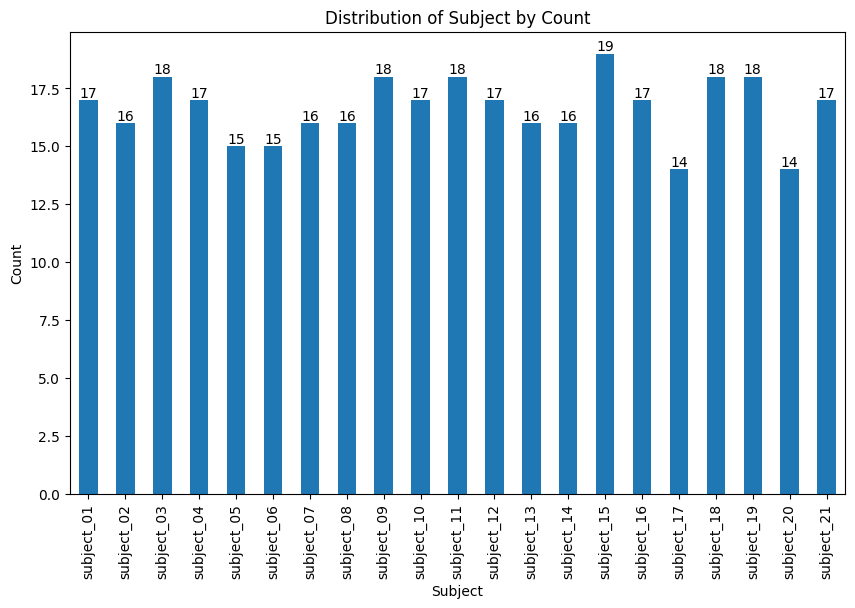

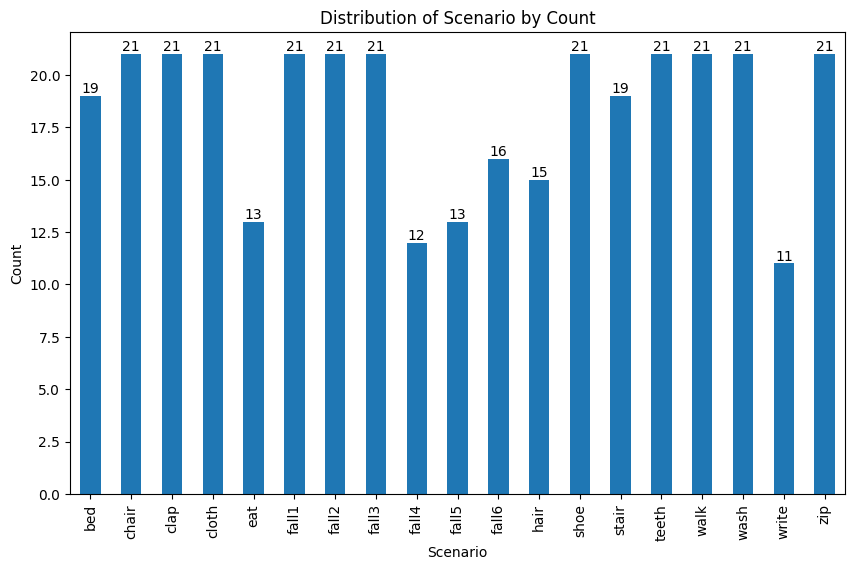

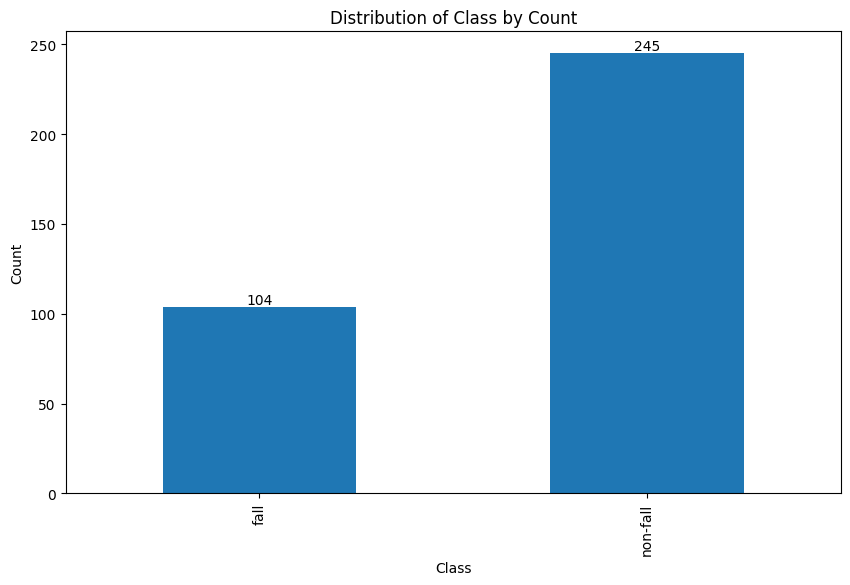

In [6]:
""" Plot distribution of columns by count """
for column in ['subject', 'scenario', 'class']:
    # Get value counts and sort by index
    value_counts = df_dataset[column].value_counts().sort_index()

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    ax = value_counts.plot(kind='bar')
    plt.title(f'Distribution of {column.capitalize()} by Count')
    plt.xlabel(column.capitalize())
    plt.ylabel('Count')

    # Add value labels on top of each bar
    for idx, value in enumerate(value_counts):
        ax.text(idx, value, str(value), ha='center', va='bottom')
    plt.show()

We observe 14 common scenarios found across all 21 subjects. We will perform federated learning using each of the 21 subjects as a separate localised client device.

Specifically, class imbalances occured due to non-full participation of subjects in the following scenarios:
- `fall`
    - `fall4`
    - `fall5`
    - `fall6`
- `non-fall`
    - `bed`
    - `eat`
    - `hair`
    - `stair`
    - `white`

### Distribution of Class (FD events for binary classification) and Scenario (HAR activities for multi-class classification) for each Subject

In [ ]:
# Preview dataset
df_dataset

,subject,age,sex,class,scenario,time,w,x,y,z,droll,dpitch,dyaw,ax,ay,az,heart,scenario_encoded,class_encoded
0,subject_01,31,Male,fall,fall1,"[[2018.0, 5.0, 11.0, 13.0, 17.0, 2.825], [2018...","[[-0.8331], [-0.8331], [-0.8331], [-0.8331], [...","[[0.4897], [0.4897], [0.4897], [0.4897], [0.48...","[[0.1678], [0.1679], [0.168], [0.1679], [0.168...","[[-0.1942], [-0.1942], [-0.1942], [-0.1943], [...","[[-0.7], [-0.9], [-0.4], [-0.4], [-0.5], [-0.8...","[[0.0], [0.2], [0.1], [0.2], [0.2], [0.1], [0....","[[1.1], [0.8], [0.8], [0.9], [1.1], [0.9], [1....","[[0.016], [0.015], [0.018], [0.016], [0.015], ...","[[0.014], [0.01], [0.012], [0.013], [0.012], [...","[[0.002], [0.006], [0.002], [0.002], [0.008], ...","[[1023], [1023], [1023], [1023], [1023], [1023...",5,0
1,subject_01,31,Male,fall,fall2,"[[2018.0, 5.0, 11.0, 13.0, 23.0, 23.547], [201...","[[-0.2803], [-0.2803], [-0.2802], [-0.2802], [...","[[-0.6516], [-0.6518], [-0.652], [-0.6521], [-...","[[0.6375], [0.6374], [0.6372], [0.637], [0.636...","[[0.3003], [0.3003], [0.3003], [0.3003], [0.30...","[[-0.4], [-0.6], [-0.5], [-0.6], [-0.6], [-0.9...","[[0.0], [0.2], [0.2], [0.1], [0.1], [0.2], [0....","[[0.8], [0.8], [0.8], [0.8], [0.8], [1.1], [1....","[[-0.013], [-0.013], [-0.014], [-0.011], [-0.0...","[[0.002], [0.002], [0.002], [0.002], [-0.001],...","[[-0.016], [-0.012], [-0.015], [-0.012], [-0.0...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...",6,0
2,subject_01,31,Male,fall,fall3,"[[2018.0, 5.0, 11.0, 13.0, 30.0, 57.327], [201...","[[0.4041], [0.4042], [0.4042], [0.4042], [0.40...","[[-0.2569], [-0.257], [-0.257], [-0.257], [-0....","[[0.0057], [0.0059], [0.006], [0.0061], [0.006...","[[-0.8778], [-0.8777], [-0.8777], [-0.8777], [...","[[-1.2], [-1.4], [-1.2], [-0.9], [-0.9], [-0.5...","[[-0.1], [-0.1], [-0.1], [-0.2], [-0.2], [0.1]...","[[0.5], [0.6], [0.9], [1.0], [1.2], [1.4], [1....","[[0.004], [0.0], [0.003], [0.009], [0.015], [0...","[[0.001], [-0.004], [-0.002], [0.0], [0.0], [-...","[[-0.002], [0.001], [-0.003], [0.001], [-0.002...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...",7,0
3,subject_01,31,Male,fall,fall4,"[[2018.0, 5.0, 11.0, 13.0, 32.0, 40.959], [201...","[[0.6932], [0.6934], [0.6932], [0.6931], [0.69...","[[-0.3212], [-0.3212], [-0.3213], [-0.3214], [...","[[0.3334], [0.3334], [0.3334], [0.3335], [0.33...","[[-0.5522], [-0.552], [-0.5522], [-0.5521], [-...","[[-0.4], [-0.8], [-1.2], [-1.3], [-0.7], [-0.4...","[[0.2], [0.1], [-0.1], [0.0], [0.0], [0.1], [0...","[[0.8], [0.8], [1.0], [0.8], [1.0], [0.8], [0....","[[0.008], [0.012], [0.014], [0.014], [0.015], ...","[[0.017], [0.014], [0.017], [0.017], [0.011], ...","[[0.0], [0.0], [0.0], [-0.002], [-0.003], [0.0...","[[1023], [1023], [1023], [1023], [1023], [0], ...",8,0
4,subject_01,31,Male,fall,fall6,"[[2018.0, 5.0, 11.0, 13.0, 36.0, 19.385], [201...","[[0.124], [0.124], [0.124], [0.124], [0.1239],...","[[0.9614], [0.9615], [0.9615], [0.9616], [0.96...","[[-0.2451], [-0.2449], [-0.2448], [-0.2446], [...","[[-0.0084], [-0.0083], [-0.0083], [-0.0083], [...","[[-0.6], [-0.4], [-0.6], [-0.7], [-0.7], [-0.6...","[[0.1], [0.0], [0.0], [0.0], [0.0], [0.2], [0....","[[0.8], [0.9], [0.8], [0.8], [1.0], [1.0], [1....","[[-0.005], [-0.008], [-0.006], [-0.007], [-0.0...","[[-0.012], [-0.008], [-0.008], [-0.008], [-0.0...","[[-0.009], [-0.008], [-0.013], [-0.008], [-0.0...","[[0], [0], [0], [0], [0], [0], [1023], [1023],...",10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,subject_21,30,Male,non-fall,teeth,"[[2018.0, 4.0, 25.0, 16.0, 52.0, 56.44], [2018...","[[-0.3084], [-0.3072], [-0.3109], [-0.3174], [...","[[-0.1616], [-0.1538], [-0.155], [-0.1635], [-...","[[-0.3318], [-0.3356], [-0.3366], [-0.3349], [...","[[0.8766], [0.877], [0.8751], [0.8719], [0.868...","[[-39.2], [-21.6], [1.3], [20.7], [16.9], [-10...","[[46.4], [14.7], [-17.2], [-39.4], [-48.4], [-...","[[46.5], [2.6], [-43.6], [-64.6], [-62.3], [-4...","[[-0.094], [-0.001], [0.092], [0.074], [-0.009...","[[-

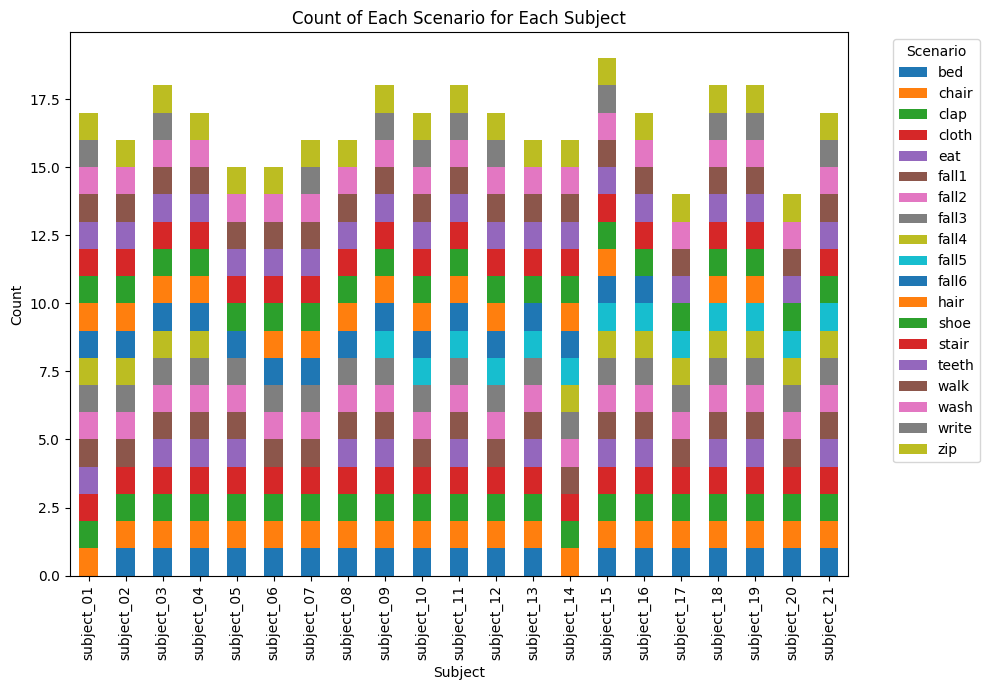

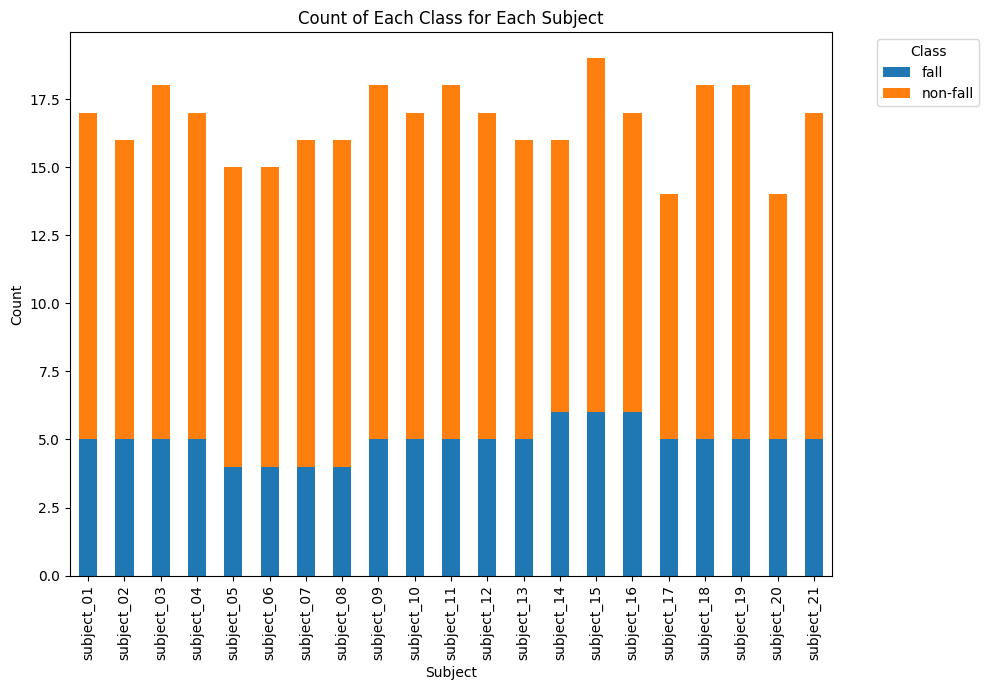

In [8]:
# Group by subject and scenario, then count occurrences
scenario_count = df_dataset.groupby(['subject', 'scenario']).size().reset_index(name='count')

# Pivot the data for plotting
pivot_scenario = scenario_count.pivot_table(index='subject', columns='scenario', values='count', fill_value=0)

# Plot the scenario count
pivot_scenario.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Count of Each Scenario for Each Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Group by subject and class, then count occurrences
class_count = df_dataset.groupby(['subject', 'class']).size().reset_index(name='count')

# Pivot the data for plotting
pivot_class = class_count.pivot_table(index='subject', columns='class', values='count', fill_value=0)

# Plot the class count
pivot_class.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Count of Each Class for Each Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Distribution of Data by Subjects

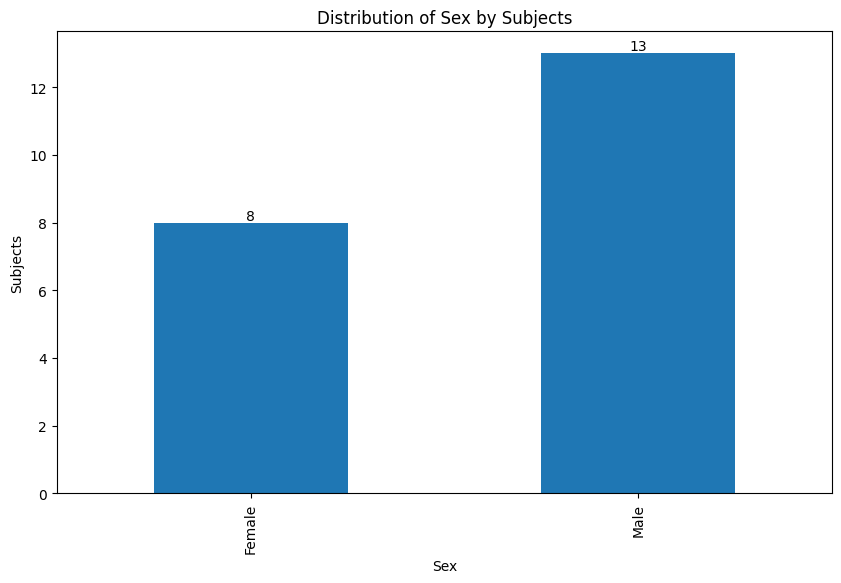

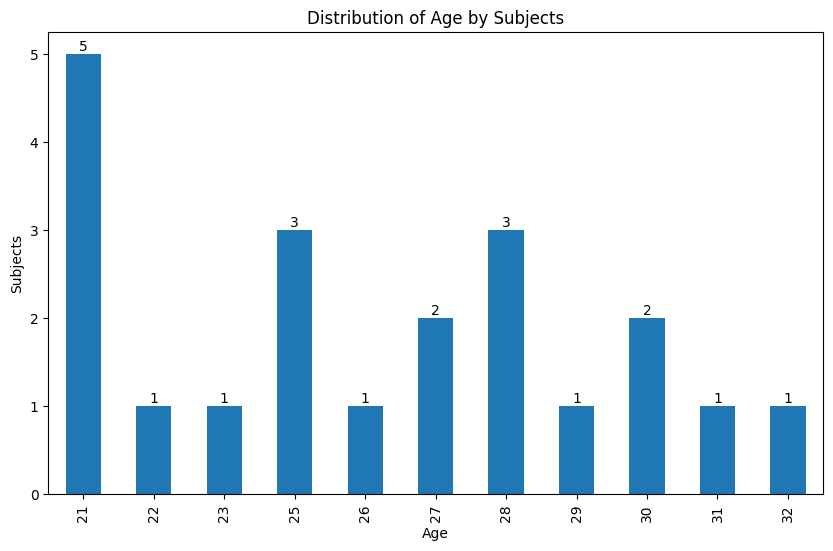

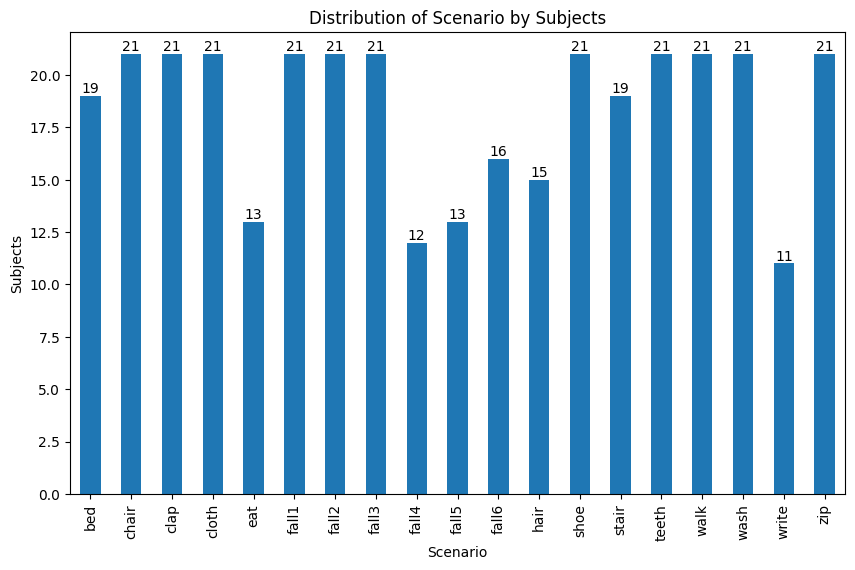

In [9]:
""" Plot distribution of columns by subjects """
for column in ['sex', 'age', 'scenario']:
    # Compute value counts based on unique subjects
    value_counts = df_dataset.groupby(column)['subject'].nunique().sort_index()
    
    # Plot bar chart
    plt.figure(figsize=(10, 6))
    ax = value_counts.plot(kind='bar')
    plt.title(f'Distribution of {column.capitalize()} by Subjects')
    plt.xlabel(column.capitalize())
    plt.ylabel('Subjects')
    
    # Add value labels on top of each bar
    for idx, value in enumerate(value_counts):
        ax.text(idx, value, str(value), ha='center', va='bottom')
    plt.show()

## Split dataset into Training and Validation Sets
Due to complexities in catering to inherent feature imbalances within the dataset, we perform a simple `80:20` train-test split based on subjects. Federated learning will be subsequently performed with each subject acting as a standalone local device.

This dataset subsetting results in both seen and unseen subject data subsets:
- Seen Subjects
    - Used for training local client models, and local model testing
- Unseen Subjects
    - Used for testing of models, not used for any form of training

In [10]:
# Split subjects into train and validation
subject_counts = df_dataset['subject'].value_counts()
val_subjects = subject_counts.sample(frac=SPLIT_SIZE, random_state=RAND_SEED).index
train_subjects = subject_counts[~subject_counts.index.isin(val_subjects)].index

# Create train and validation datasets
df_train = df_dataset[df_dataset['subject'].isin(train_subjects)]
df_val = df_dataset[df_dataset['subject'].isin(val_subjects)]
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)

# Export dataframe
pickle_object(df_train, TRAIN_DATASET_FILE)
pickle_object(df_val, VAL_DATASET_FILE)

In [11]:
# Preview train and validation dataset subjects
print("Training subjects:", train_subjects, len(train_subjects), end='\n\n')
print("Validation subjects:", val_subjects, len(val_subjects))

Training subjects: Index(['subject_15', 'subject_11', 'subject_03', 'subject_19', 'subject_18',
       'subject_09', 'subject_10', 'subject_16', 'subject_12', 'subject_04',
       'subject_21', 'subject_13', 'subject_14', 'subject_07', 'subject_06',
       'subject_05', 'subject_17'],
      dtype='object', name='subject') 17

Validation subjects: Index(['subject_20', 'subject_08', 'subject_02', 'subject_01'], dtype='object', name='subject') 4


Subjects 1, 2, 8 and 20 will solely be used to test the models' performance, whereas the remaining subjects will be used for both local training and global aggregated training.

#### Preview Training Dataset

In [12]:
print("Dimensions of training dataset:", df_train.shape)

Dimensions of training dataset: (286, 19)


In [13]:
df_train.head()

,subject,age,sex,class,scenario,time,w,x,y,z,droll,dpitch,dyaw,ax,ay,az,heart,scenario_encoded,class_encoded
0,subject_03,28,Male,fall,fall1,"[[2018.0, 4.0, 24.0, 22.0, 45.0, 27.845], [201...","[[0.2141], [0.214], [0.2141], [0.2141], [0.214...","[[-0.124], [-0.1239], [-0.124], [-0.1241], [-0...","[[-0.2819], [-0.2816], [-0.2816], [-0.2818], [...","[[0.9269], [0.927], [0.927], [0.9269], [0.9269...","[[1.4], [0.0], [-1.0], [-0.7], [0.0], [0.0], [...","[[0.3], [0.0], [-0.2], [-0.2], [0.0], [0.0], [...","[[-0.2], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[0.001], [-0.002], [-0.002], [0.0], [0.0], [-...","[[0.018], [0.024], [0.013], [0.004], [0.006], ...","[[-0.015], [-0.012], [-0.012], [-0.007], [-0.0...","[[1023], [1023], [1023], [1023], [1023], [1023...",5,0
1,subject_03,28,Male,fall,fall2,"[[2018.0, 4.0, 24.0, 22.0, 0.0, 0.02], [2018.0...","[[0.1301], [0.1301], [0.1301], [0.1301], [0.13...","[[0.0008], [0.0008], [0.0008], [0.0007], [0.00...","[[0.4273], [0.4272], [0.4271], [0.4272], [0.42...","[[-0.8946], [-0.8947], [-0.8947], [-0.8947], [...","[[0.7], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.3], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[-0.004], [-0.007], [-0.005], [-0.005], [-0.0...","[[0.017], [0.017], [0.012], [0.004], [0.006], ...","[[-0.01], [-0.008], [-0.008], [-0.011], [-0.01...","[[1023], [1023], [1023], [1023], [1023], [1023...",6,0
2,subject_03,28,Male,fall,fall3,"[[2018.0, 4.0, 24.0, 23.0, 13.0, 39.353], [201...","[[-0.0177], [-0.0177], [-0.0177], [-0.0178], [...","[[-0.227], [-0.227], [-0.2269], [-0.2268], [-0...","[[0.2847], [0.2846], [0.2847], [0.2848], [0.28...","[[-0.9311], [-0.9311], [-0.9311], [-0.9311], [...","[[0.0], [-0.4], [-0.8], [-0.4], [-0.7], [-0.6]...","[[0.0], [-0.4], [-0.4], [-0.4], [-0.4], [-0.3]...","[[0.0], [-0.5], [-0.4], [-0.5], [-0.6], [-0.6]...","[[0.005], [0.005], [0.007], [0.006], [0.006], ...","[[0.008], [0.018], [0.009], [0.003], [0.014], ...","[[-0.001], [-0.012], [-0.009], [-0.004], [-0.0...","[[1023], [1023], [1023], [1023], [1023], [1023...",7,0
3,subject_03,28,Male,fall,fall4,"[[2018.0, 4.0, 24.0, 23.0, 16.0, 17.987], [201...","[[0.2212], [0.2212], [0.2212], [0.2212], [0.22...","[[-0.043], [-0.043], [-0.043], [-0.043], [-0.0...","[[0.3383], [0.3383], [0.3383], [0.3382], [0.33...","[[-0.9136], [-0.9136], [-0.9136], [-0.9136], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [-0.003], [-0.003], [-0.001], [-0.001]...","[[0.009], [0.008], [0.009], [0.009], [0.008], ...","[[-0.014], [-0.012], [-0.006], [-0.013], [-0.0...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...",8,0
4,subject_03,28,Male,fall,fall6,"[[2018.0, 4.0, 24.0, 23.0, 20.0, 59.831], [201...","[[0.4924], [0.4923], [0.4922], [0.4922], [0.49...","[[-0.2613], [-0.2614], [-0.2614], [-0.2614], [...","[[0.813], [0.813], [0.813], [0.8131], [0.8131]...","[[0.1679], [0.168], [0.168], [0.168], [0.168],...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.002], [0.003], [0.002], [0.0], [0.003], [0...","[[0.001], [0.002], [0.001], [0.003], [0.002], ...","[[-0.01], [-0.007], [-0.006], [0.0], [0.0], [-...","[[1023], [1023], [1023], [1023], [1023], [1023...",10,0


#### Preview Validation Dataset

In [14]:
print("Dimensions of validation dataset:", df_val.shape)

Dimensions of validation dataset: (63, 19)


In [15]:
df_val.head()

,subject,age,sex,class,scenario,time,w,x,y,z,droll,dpitch,dyaw,ax,ay,az,heart,scenario_encoded,class_encoded
0,subject_01,31,Male,fall,fall1,"[[2018.0, 5.0, 11.0, 13.0, 17.0, 2.825], [2018...","[[-0.8331], [-0.8331], [-0.8331], [-0.8331], [...","[[0.4897], [0.4897], [0.4897], [0.4897], [0.48...","[[0.1678], [0.1679], [0.168], [0.1679], [0.168...","[[-0.1942], [-0.1942], [-0.1942], [-0.1943], [...","[[-0.7], [-0.9], [-0.4], [-0.4], [-0.5], [-0.8...","[[0.0], [0.2], [0.1], [0.2], [0.2], [0.1], [0....","[[1.1], [0.8], [0.8], [0.9], [1.1], [0.9], [1....","[[0.016], [0.015], [0.018], [0.016], [0.015], ...","[[0.014], [0.01], [0.012], [0.013], [0.012], [...","[[0.002], [0.006], [0.002], [0.002], [0.008], ...","[[1023], [1023], [1023], [1023], [1023], [1023...",5,0
1,subject_01,31,Male,fall,fall2,"[[2018.0, 5.0, 11.0, 13.0, 23.0, 23.547], [201...","[[-0.2803], [-0.2803], [-0.2802], [-0.2802], [...","[[-0.6516], [-0.6518], [-0.652], [-0.6521], [-...","[[0.6375], [0.6374], [0.6372], [0.637], [0.636...","[[0.3003], [0.3003], [0.3003], [0.3003], [0.30...","[[-0.4], [-0.6], [-0.5], [-0.6], [-0.6], [-0.9...","[[0.0], [0.2], [0.2], [0.1], [0.1], [0.2], [0....","[[0.8], [0.8], [0.8], [0.8], [0.8], [1.1], [1....","[[-0.013], [-0.013], [-0.014], [-0.011], [-0.0...","[[0.002], [0.002], [0.002], [0.002], [-0.001],...","[[-0.016], [-0.012], [-0.015], [-0.012], [-0.0...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...",6,0
2,subject_01,31,Male,fall,fall3,"[[2018.0, 5.0, 11.0, 13.0, 30.0, 57.327], [201...","[[0.4041], [0.4042], [0.4042], [0.4042], [0.40...","[[-0.2569], [-0.257], [-0.257], [-0.257], [-0....","[[0.0057], [0.0059], [0.006], [0.0061], [0.006...","[[-0.8778], [-0.8777], [-0.8777], [-0.8777], [...","[[-1.2], [-1.4], [-1.2], [-0.9], [-0.9], [-0.5...","[[-0.1], [-0.1], [-0.1], [-0.2], [-0.2], [0.1]...","[[0.5], [0.6], [0.9], [1.0], [1.2], [1.4], [1....","[[0.004], [0.0], [0.003], [0.009], [0.015], [0...","[[0.001], [-0.004], [-0.002], [0.0], [0.0], [-...","[[-0.002], [0.001], [-0.003], [0.001], [-0.002...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...",7,0
3,subject_01,31,Male,fall,fall4,"[[2018.0, 5.0, 11.0, 13.0, 32.0, 40.959], [201...","[[0.6932], [0.6934], [0.6932], [0.6931], [0.69...","[[-0.3212], [-0.3212], [-0.3213], [-0.3214], [...","[[0.3334], [0.3334], [0.3334], [0.3335], [0.33...","[[-0.5522], [-0.552], [-0.5522], [-0.5521], [-...","[[-0.4], [-0.8], [-1.2], [-1.3], [-0.7], [-0.4...","[[0.2], [0.1], [-0.1], [0.0], [0.0], [0.1], [0...","[[0.8], [0.8], [1.0], [0.8], [1.0], [0.8], [0....","[[0.008], [0.012], [0.014], [0.014], [0.015], ...","[[0.017], [0.014], [0.017], [0.017], [0.011], ...","[[0.0], [0.0], [0.0], [-0.002], [-0.003], [0.0...","[[1023], [1023], [1023], [1023], [1023], [0], ...",8,0
4,subject_01,31,Male,fall,fall6,"[[2018.0, 5.0, 11.0, 13.0, 36.0, 19.385], [201...","[[0.124], [0.124], [0.124], [0.124], [0.1239],...","[[0.9614], [0.9615], [0.9615], [0.9616], [0.96...","[[-0.2451], [-0.2449], [-0.2448], [-0.2446], [...","[[-0.0084], [-0.0083], [-0.0083], [-0.0083], [...","[[-0.6], [-0.4], [-0.6], [-0.7], [-0.7], [-0.6...","[[0.1], [0.0], [0.0], [0.0], [0.0], [0.2], [0....","[[0.8], [0.9], [0.8], [0.8], [1.0], [1.0], [1....","[[-0.005], [-0.008], [-0.006], [-0.007], [-0.0...","[[-0.012], [-0.008], [-0.008], [-0.008], [-0.0...","[[-0.009], [-0.008], [-0.013], [-0.008], [-0.0...","[[0], [0], [0], [0], [0], [0], [1023], [1023],...",10,0


After the train-test split based on subjects, we proceed on extracting the sensor readings for each data subset.

## Expand Datasets
Expand datasets to account for sensor readings which are stored as multi-dimensional lists.

In [ ]:
# Expand datasets
df_dataset_expand = expand_sensor_data(df_dataset, ['time', 'w', 'x', 'y', 'z', 'droll', 'dpitch', 'dyaw', 'ax', 'ay', 'az', 'heart'])
df_train_expand = expand_sensor_data(df_train, ['time', 'w', 'x', 'y', 'z', 'droll', 'dpitch', 'dyaw', 'ax', 'ay', 'az', 'heart'])
df_val_expand = expand_sensor_data(df_val, ['time', 'w', 'x', 'y', 'z', 'droll', 'dpitch', 'dyaw', 'ax', 'ay', 'az', 'heart'])

# Save expanded datasets
pickle_object(df_dataset_expand, EXPANDED_DATASET_FILE)
pickle_object(df_train_expand, EXPANDED_TRAIN_DATASET_FILE)
pickle_object(df_val_expand, EXPANDED_VAL_DATASET_FILE)

### Preview expanded datasets

#### Expanded Dataset

In [ ]:
print("Dimensions of full expanded dataset:", df_dataset_expand.shape)

Dimensions of full expanded dataset: (381394, 17)


In [ ]:
df_dataset_expand

,subject,age,sex,class,scenario,time,w,x,y,z,droll,dpitch,dyaw,ax,ay,az,heart
0,subject_01,31,Male,fall,fall1,2018-05-11 13:17:02.825000,-0.8331,0.4897,0.1678,-0.1942,-0.7,0.0,1.1,0.016,0.014,0.002,1023
1,subject_01,31,Male,fall,fall1,2018-05-11 13:17:02.828999,-0.8331,0.4897,0.1679,-0.1942,-0.9,0.2,0.8,0.015,0.010,0.006,1023
2,subject_01,31,Male,fall,fall1,2018-05-11 13:17:02.847000,-0.8331,0.4897,0.1680,-0.1942,-0.4,0.1,0.8,0.018,0.012,0.002,1023
3,subject_01,31,Male,fall,fall1,2018-05-11 13:17:02.884999,-0.8331,0.4897,0.1679,-0.1943,-0.4,0.2,0.9,0.016,0.013,0.002,1023
4,subject_01,31,Male,fall,fall1,2018-05-11 13:17:02.905000,-0.8332,0.4895,0.1681,-0.1943,-0.5,0.2,1.1,0.015,0.012,0.008,1023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381389,subject_21,30,Male,non-fall,zip,2018-04-25 17:01:10.295999,0.0770,0.0251,-0.5638,0.8218,26.4,-19.8,3.1,-0.015,0.063,0.010,1023
381390,subject_21,30,Male,non-fall,zip,2018-04-25 17:01:10.335000,0.0799,0.0237,-0.5584,0.8253,37.8,-19.9,10.6,-0.022,0.114,0.015,1023
381391,subject_21,30,Male,non-fall,zip,2018-04-25 17:01:10.353999,0.0836,0.0232,-0.5521,0.8292,39.3,-18.8,16.0,-0.010,0.112,-0.039,1023
381392,subject_21,30,Male,non-fall,zip,2018-04-25 17:01:10.358000,0.0877,0.0233,-0.5463,0.8325,37.5,-15.4,20.2,-0.007,0.089,-0.072,1023


#### Expanded Training Dataset

In [ ]:
print("Dimensions of expanded training dataset:", df_train_expand.shape)

Dimensions of expanded training dataset: (311195, 17)


In [ ]:
df_train_expand

,subject,age,sex,class,scenario,time,w,x,y,z,droll,dpitch,dyaw,ax,ay,az,heart
0,subject_03,28,Male,fall,fall1,2018-04-24 22:45:27.844999,0.2141,-0.1240,-0.2819,0.9269,1.4,0.3,-0.2,0.001,0.018,-0.015,1023
1,subject_03,28,Male,fall,fall1,2018-04-24 22:45:27.868999,0.2140,-0.1239,-0.2816,0.9270,0.0,0.0,0.0,-0.002,0.024,-0.012,1023
2,subject_03,28,Male,fall,fall1,2018-04-24 22:45:27.887000,0.2141,-0.1240,-0.2816,0.9270,-1.0,-0.2,0.0,-0.002,0.013,-0.012,1023
3,subject_03,28,Male,fall,fall1,2018-04-24 22:45:27.905000,0.2141,-0.1241,-0.2818,0.9269,-0.7,-0.2,0.0,0.000,0.004,-0.007,1023
4,subject_03,28,Male,fall,fall1,2018-04-24 22:45:27.922000,0.2141,-0.1241,-0.2818,0.9269,0.0,0.0,0.0,0.000,0.006,-0.011,1023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311190,subject_21,30,Male,non-fall,zip,2018-04-25 17:01:10.295999,0.0770,0.0251,-0.5638,0.8218,26.4,-19.8,3.1,-0.015,0.063,0.010,1023
311191,subject_21,30,Male,non-fall,zip,2018-04-25 17:01:10.335000,0.0799,0.0237,-0.5584,0.8253,37.8,-19.9,10.6,-0.022,0.114,0.015,1023
311192,subject_21,30,Male,non-fall,zip,2018-04-25 17:01:10.353999,0.0836,0.0232,-0.5521,0.8292,39.3,-18.8,16.0,-0.010,0.112,-0.039,1023
311193,subject_21,30,Male,non-fall,zip,2018-04-25 17:01:10.358000,0.0877,0.0233,-0.5463,0.8325,37.5,-15.4,20.2,-0.007,0.089,-0.072,1023


#### Expanded Validation Dataset

In [ ]:
print("Dimensions of expanded validation dataset:", df_val_expand.shape)

Dimensions of expanded validation dataset: (70199, 17)


In [ ]:
df_val_expand

,subject,age,sex,class,scenario,time,w,x,y,z,droll,dpitch,dyaw,ax,ay,az,heart
0,subject_01,31,Male,fall,fall1,2018-05-11 13:17:02.825000,-0.8331,0.4897,0.1678,-0.1942,-0.7,0.0,1.1,0.016,0.014,0.002,1023
1,subject_01,31,Male,fall,fall1,2018-05-11 13:17:02.828999,-0.8331,0.4897,0.1679,-0.1942,-0.9,0.2,0.8,0.015,0.010,0.006,1023
2,subject_01,31,Male,fall,fall1,2018-05-11 13:17:02.847000,-0.8331,0.4897,0.1680,-0.1942,-0.4,0.1,0.8,0.018,0.012,0.002,1023
3,subject_01,31,Male,fall,fall1,2018-05-11 13:17:02.884999,-0.8331,0.4897,0.1679,-0.1943,-0.4,0.2,0.9,0.016,0.013,0.002,1023
4,subject_01,31,Male,fall,fall1,2018-05-11 13:17:02.905000,-0.8332,0.4895,0.1681,-0.1943,-0.5,0.2,1.1,0.015,0.012,0.008,1023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70194,subject_20,21,Female,non-fall,zip,2018-05-17 22:09:04.435999,-0.0178,0.4043,0.0661,-0.9120,-22.1,-11.7,24.3,-0.010,-0.211,-0.148,0
70195,subject_20,21,Female,non-fall,zip,2018-05-17 22:09:04.455000,-0.0191,0.4063,0.0716,-0.9106,-30.1,-15.6,14.5,0.016,-0.132,-0.090,0
70196,subject_20,21,Female,non-fall,zip,2018-05-17 22:09:04.472999,-0.0190,0.4092,0.0776,-0.9089,-30.5,-17.8,7.6,0.028,-0.046,-0.035,0
70197,subject_20,21,Female,non-fall,zip,2018-05-17 22:09:04.496000,-0.0181,0.4124,0.0824,-0.9070,-24.8,-19.4,4.0,0.040,0.024,0.037,0


We will use these expanded datasets to train our federated global and local models, as well as the standalone comparative model.